In [6]:
!pip install tensorflow

  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 21.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 58.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 55.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 53.7 MB/s eta 0:00:00
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1

[notice] A new

In [4]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 35.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 52.9 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp312-cp312-linux_x86_64.whl size=1029185 sha256=ea387ee33950771912bc0e9c55fd0e649993fff31b90e4f5d3ae315ae8cf5668
  Stored in directory: /home/codespace/.cache/pip/wheels/8f/65/34/456800445efeafb05164fe95285c70e81ba1d96bae30f43917
Successfully built peewee

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [8]:

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Step 1: Fetch AAPL data using yfinance
def fetch_data(ticker, period="1y", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)
    data['Price_Change'] = data['Close'].diff()
    data.dropna(inplace=True)
    return data

# Step 2: Preprocessing
def preprocess_data(data, look_back=10):
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[features])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(data['Price_Change'].values[i])
    
    X, y = np.array(X), np.array(y)
    y = np.expand_dims(y, axis=1)  # Make y 2D for compatibility with TensorFlow
    return X, y, scaler

# Step 3: Build the LSTM model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Step 4: Main workflow
if __name__ == "__main__":
    ticker = "AAPL"
    data = fetch_data(ticker)
    
    look_back = 10  # Number of past days to consider for each prediction
    X, y, scaler = preprocess_data(data, look_back=look_back)
    
    # Split into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Build and train the LSTM model
    model = build_lstm(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    # Predictions
    predictions = model.predict(X_test)

    # Inverse transform only the target column
    price_change_scaler = MinMaxScaler(feature_range=(0, 1))
    price_change_scaler.min_, price_change_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
    predictions = price_change_scaler.inverse_transform(predictions)

    # Add predictions to the data
    data['Predicted_Price_Change'] = np.nan
    data.iloc[train_size + look_back:, -1] = predictions.flatten()
    print(data.tail())

[*********************100%***********************]  1 of 1 completed


Epoch 1/20


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 8.8097 - val_loss: 6.8983
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.4455 - val_loss: 6.9012
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.8951 - val_loss: 6.9593
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 9.3328 - val_loss: 6.9820
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.9675 - val_loss: 7.0007
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.7217 - val_loss: 7.0052
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.9020 - val_loss: 6.9553
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.8193 - val_loss: 6.9315
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.3871 - val_loss: 6.9366
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.3758 - val_loss: 6.9499
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7709 - val_loss: 7.0230
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8790 - val_loss: 7.0030
Epoch 13/20

[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 7.8175 - val_loss: 6.9107
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.7860 - val_loss: 6.9182
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8250 - val_loss: 6.9111
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1114 - val_loss: 6.9111
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1237 - val_loss: 6.9041
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.6704 - val_loss: 6.9113
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.6631 - val_loss: 6.9201
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3290 - val_loss: 6.9294
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7326 - val_loss: 6.9348
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.9727 - val_loss: 6.9772
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0958 - val_loss: 6.9766
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.7435 - val_loss: 6.9717
Epoch 13/20


/tmp/ipykernel_5836/4116608788.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predictions = np.cumsum(predictions) + float(last_close_price)  # Start with the last known price


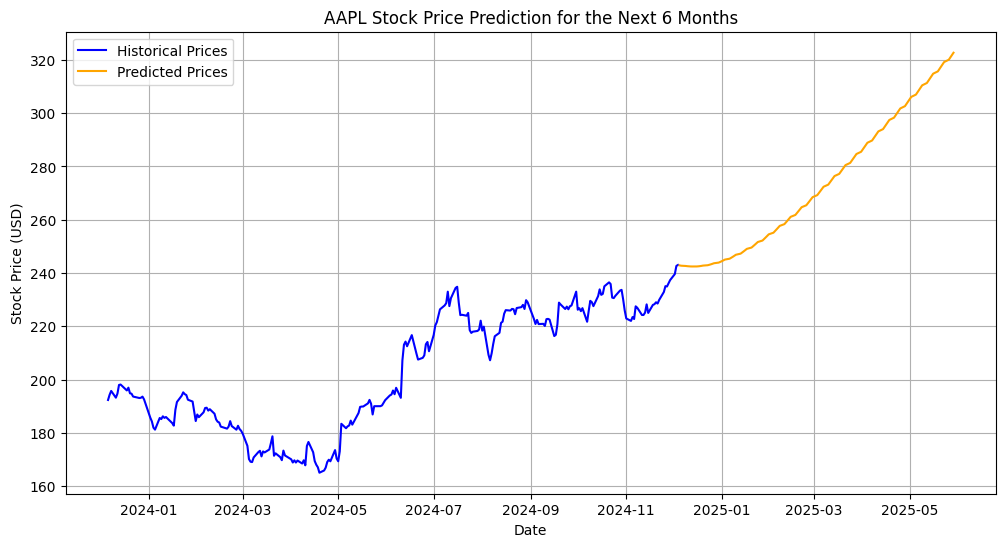

In [13]:
import matplotlib.pyplot as plt

# Fetch historical data
def fetch_data(ticker, period="1y", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)
    data['Price_Change'] = data['Close'].diff()
    data.dropna(inplace=True)
    return data

# Preprocess the data
def preprocess_data(data, look_back=10):
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[features])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(data['Price_Change'].values[i])  # Predict price changes
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Build the LSTM model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Predict future prices
def predict_future(model, last_sequence, future_steps, scaler, last_close_price):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(future_steps):
        pred = model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)
        pred_reshaped = pred.flatten()  # Ensure it's a 1D array

        # Add prediction as a new row with the correct number of features
        new_row = np.zeros((1, current_sequence.shape[1]))
        new_row[0, -1] = pred_reshaped[0]  # Fill in only the predicted column

        # Append the new row and drop the first row
        current_sequence = np.append(current_sequence[1:], new_row, axis=0)
        predictions.append(pred_reshaped[0])
    
    # Convert predictions (price changes) to stock prices
    predictions = np.array(predictions)
    predictions = np.cumsum(predictions) + float(last_close_price)  # Start with the last known price

    return predictions

# Main workflow
if __name__ == "__main__":
    ticker = "AAPL"
    data = fetch_data(ticker)
    look_back = 10

    X, y, scaler = preprocess_data(data, look_back=look_back)
    
    # Split into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train the LSTM model
    model = build_lstm(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predict the next 6 months
    future_steps = 126  # Approximately 6 months (21 trading days per month)
    last_sequence = X[-1]  # Use the last sequence from the dataset
    last_close_price = data['Close'].iloc[-1]  # Start predictions from the last close price
    future_prices = predict_future(model, last_sequence, future_steps, scaler, last_close_price)

    # Create a future date range
    last_date = data.index[-1]
    future_dates = pd.date_range(last_date, periods=future_steps + 1, freq='B')[1:]

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label="Historical Prices", color="blue")
    plt.plot(future_dates, future_prices, label="Predicted Prices", color="orange")
    plt.title("AAPL Stock Price Prediction for the Next 6 Months")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()